In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

## Load Data

In [2]:
raw_df = pd.read_csv('data/train_house_price.csv')
raw_test = pd.read_csv('data/test_house_price.csv')
X_train = raw_df.iloc[:, :-1].copy()
y_train = raw_df.iloc[:, -1].copy()

## Split into Text or Numerical Features

In [3]:
def get_features(X_train):
    '''Remove columns with nulls and split into text or numerical features'''
    cols_w_nulls = X_train.columns[X_train.isnull().sum() > 0]
    features_txt = [i for i in X_train.dtypes[X_train.dtypes=='object'].index if i not in cols_w_nulls]
    features_num = [i for i in X_train.dtypes[(X_train.dtypes=='int') | (X_train.dtypes=='float')].index
                   if i not in cols_w_nulls]
    features_num.remove('Id')
    dummy_vars = OrdinalEncoder().fit(X_train[features_txt]).categories_
    dummy_vars = [np.hstack((i, 'Unknown')) for i in dummy_vars]
    return features_num, features_txt, dummy_vars
print([len(f) for f in get_features(X_train)])
# get_features(X_train)[2]

[33, 27, 27]


## Pipeline

In [4]:
def create_pipe(model, feature_tuple):
    '''Create scikit-learn pipeline'''
    features_num, features_txt, dummy_vars = feature_tuple
    ctx = ColumnTransformer([
        ('numbers', MinMaxScaler(), features_num),
        ('txt', OneHotEncoder(categories=dummy_vars), features_txt)
    ])
    model = Pipeline([
        ('preprocessor', ctx),
#         ('scale', MinMaxScaler()),
        ('model', model)])
    return model

## Test Model

In [5]:
def test_model(model, X_train, y_train):
    '''Do cross-validation of model'''
    cv = KFold(n_splits=5, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, return_train_score=True)
    return pd.DataFrame(cv_results)

## Try Linear Regression

In [6]:
%%time
lr_model = LinearRegression()
feature_names = get_features(X_train)
model = create_pipe(lr_model, feature_names)
df_results = test_model(model, X_train, y_train)
df_results

CPU times: user 516 ms, sys: 31.2 ms, total: 547 ms
Wall time: 542 ms


,fit_time,score_time,test_score,train_score
0,0.081674,0.010325,-18375.207060,-14454.900031
1,0.089924,0.009698,-19505.372640,-14898.855852
2,0.072048,0.009321,-18144.099165,-14052.843371
3,0.076488,0.009376,-19234.676644,-13611.845054
4,0.080073,0.009401,-19154.212195,-14265.468230


## Cleanup Test Dataset

In [7]:
num_cols, txt_cols, txt_cats = feature_names
X_test = raw_test.copy()
X_test[txt_cols] = X_test[txt_cols].fillna(value='Unknown')
for cname in num_cols:
    X_test[cname] = X_test[cname].fillna(value=X_test[cname].mean())

## Prediction

In [8]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([118364.11539443, 160734.64243306, 187628.20591416, ...,
       171762.30808069, 100424.4411286 , 233922.89392519])

In [9]:
def do_scatter(x, y, trend=True):
    '''scatter plot with optional trendline'''
    name = x.name
    if not trend:
        # categorical
        categories = feature_names[2][feature_names[1].index(name)]
        x = OrdinalEncoder([categories]).fit_transform(x.to_frame())
    sns.regplot(x, y, ci=None, color='C1', fit_reg=trend, scatter_kws={'alpha': .3})
    plt.xlabel(name)
    plt.ylabel('Price (£)')
    if not trend:
        # categorical
        plt.xticks(ticks=range(len(categories)), labels=categories, rotation=90)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

In [10]:
def do_subplots(column_name, trend=True):
    fig, ax = plt.subplots(1, 2, sharex=trend, sharey=True, figsize=(12, 4))
    plt.sca(ax[0])
    do_scatter(X_train[column_name], y_train, trend=trend)
    plt.title('Training Set')
    plt.sca(ax[1])
    do_scatter(X_test[column_name], y_pred, trend=trend)
    plt.title('Test Set Predictions')

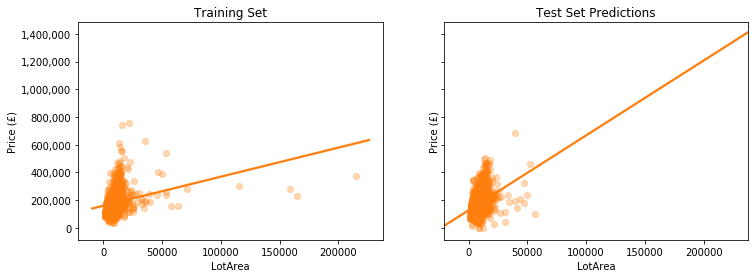

In [11]:
do_subplots('LotArea')

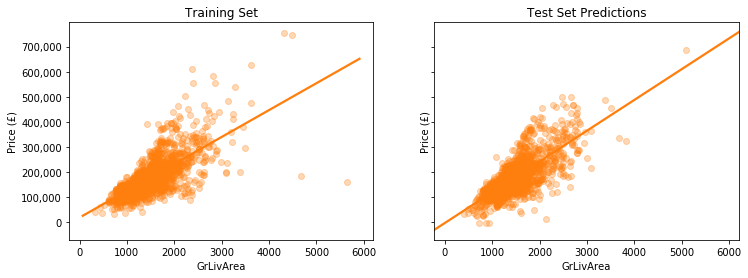

In [12]:
do_subplots('GrLivArea')

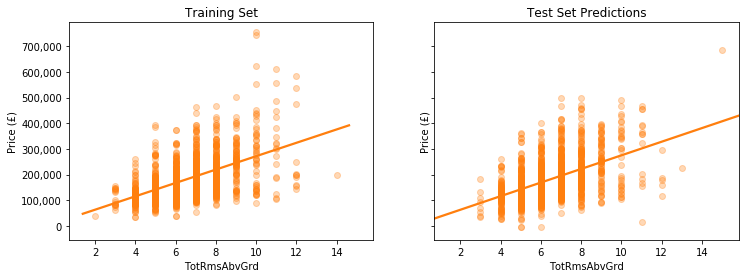

In [13]:
do_subplots('TotRmsAbvGrd')

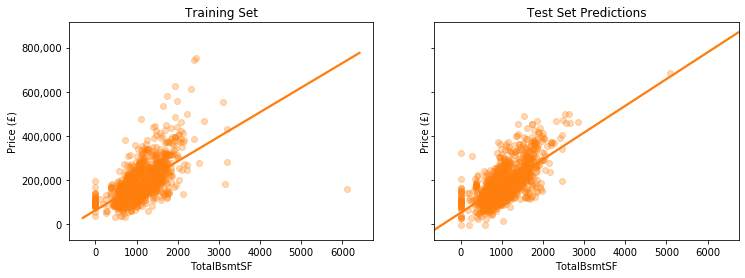

In [14]:
do_subplots('TotalBsmtSF')

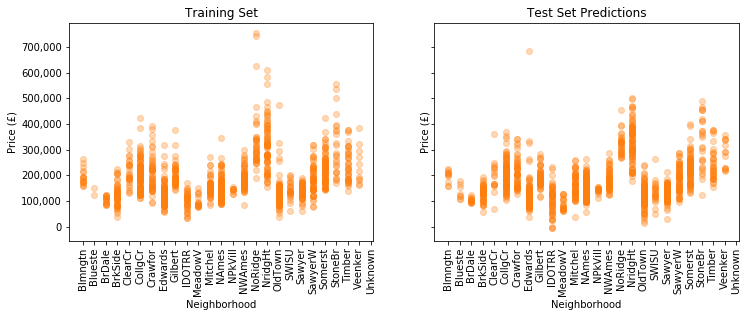

In [15]:
do_subplots('Neighborhood', trend=False)

In [16]:
print(y_pred[X_test['Neighborhood']=='StoneBr'].max())
print(y_train[X_train['Neighborhood']=='StoneBr'].max())

489045.233018273
556581


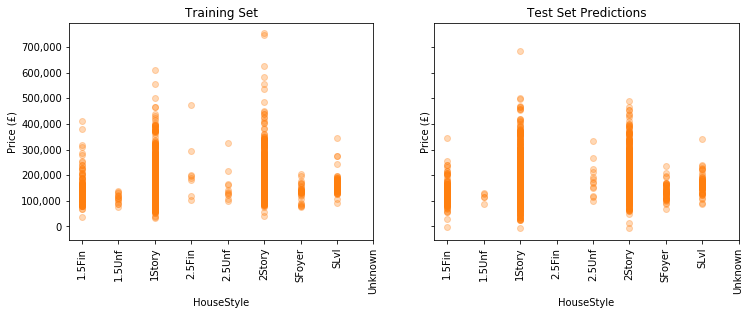

In [17]:
do_subplots('HouseStyle', trend=False)

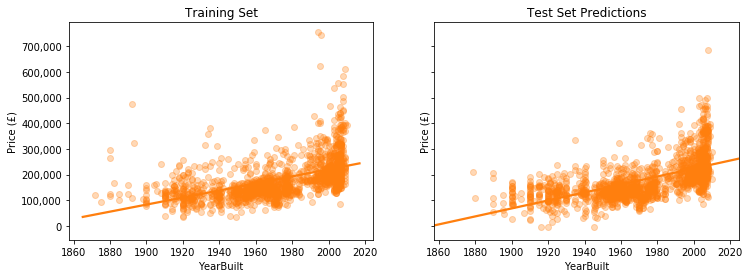

In [18]:
do_subplots('YearBuilt')

## Importances

In [19]:
onehot_names = [j for i, arr in enumerate(txt_cats) for j in txt_cols[i] + '__' + arr]
len(num_cols + onehot_names)

242

In [20]:
# dir(model.get_params()['model'])
importances = model.get_params()['model'].coef_
names = num_cols + onehot_names
df_importances = pd.DataFrame(importances, index=names, columns=['importance'])
df_rank = df_importances.sort_values(by='importance', ascending=False)
f_counts = X_train.nunique().rename('feature_count')
df_rank.merge(f_counts, how='left', left_index=True, right_index=True)

,importance,feature_count
LotArea,150185.172115,1073.0
RoofMatl__Membran,143172.628588,NaN
GrLivArea,138839.651190,861.0
RoofMatl__WdShngl,133939.341099,NaN
1stFlrSF,126289.628984,753.0
...,...,...
Exterior1st__ImStucc,-53985.814142,NaN
Functional__Sev,-55284.698386,NaN
Condition2__RRAe,-81831.192421,NaN
Condition2__PosN,-183065.624206,NaN


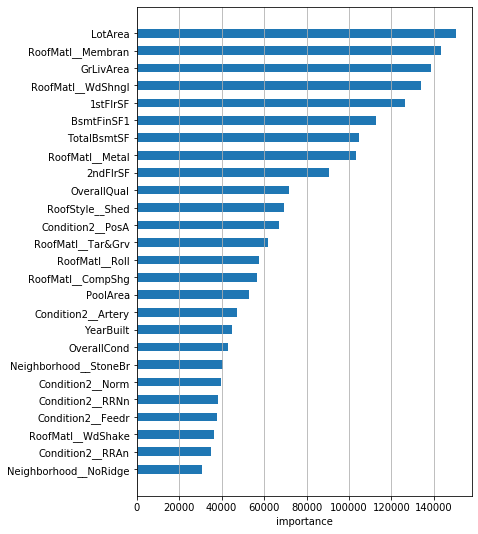

In [21]:
width = df_rank.iloc[25::-1, :]
labels = width.index
plt.figure(figsize=(6, 9))
plt.barh(labels, width.squeeze(), height=0.5)
plt.xlabel('importance')
plt.grid(axis='x')